# Simple BiLSTM using processed data trained from TSLA model

In [1]:
import sys
import tensorflow as tf
import pandas as pd 

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

cpu = tf.device('/CPU:0')
gpu = tf.device('/GPU:0')

Tensor Flow Version: 2.14.0
Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]
Pandas 1.5.3
GPU is available


2023-10-03 21:58:55.791677: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-10-03 21:58:55.791693: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-10-03 21:58:55.791699: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-10-03 21:58:55.791724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-03 21:58:55.791739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
from create_spark import CreateSparkSession

with cpu: 
    spark_obj = CreateSparkSession()
    spark = spark_obj.session

23/10/03 21:58:57 WARN Utils: Your hostname, Wonseoks-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.35.161 instead (on interface en0)
23/10/03 21:58:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/wonseokchoi/.ivy2/cache
The jars for the packages stored in: /Users/wonseokchoi/.ivy2/jars
com.amazonaws#aws-java-sdk added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
io.delta#delta-core_2.12 added as a dependency
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0ed128a7-6261-4cf9-b7ed-25dfa6f299d7;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Users/wonseokchoi/Documents/Installs/spark-3.4.1-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.amazonaws#aws-java-sdk;1.11.563 in central
	found com.amazonaws#aws-java-sdk-ioteventsdata;1.11.563 in central
	found com.amazonaws#aws-java-sdk-core;1.11.563 in central
	found commons-logging#commons-logging;1.1.3 in central
	found org.apache.httpcomponents#httpclient;4.5.5 in central
	found org.apache.httpcomponents#httpcore;4.4.9 in central
	found commons-codec#commons-codec;1.10 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found com.fasterxml.jackson.core#jackson-databind;2.6.7.2 in central
	found com.fasterxml.jackson.core#jackson-annotations;2.6.0 in central
	found com.fasterxml.jackson.core#jackson-core;2.6.7 in central
	found com.fasterxml.jackson.dataformat#jackson-dataformat-cbor;2.6.7 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.11.563 in central
	found com.amazonaws#aws-java-sdk-iotevents;1.11.563 in central
	found com.amazonaws#aws-java-sdk-iotthingsgraph;1.11.563 in central
	found com.amazonaws#

In [3]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col, to_utc_timestamp, to_timestamp
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
%matplotlib inline
import seaborn as sns
import os
from dotenv import load_dotenv
import json

In [4]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from tensorflow.keras.models import load_model

In [5]:
symbols = json.loads(os.getenv("TICKERS"))

4/4 [==============================] - 1s 56ms/step
Metrics for AAPL
Mean Absolute Error: 1.2317238520367613
Mean Squared Error: 1.740150380327655
Root Mean Squared Error: 1.3191475961118433
R-squared: 0.5601883314170979


4/4 [==============================] - 1s 69ms/step
Metrics for AMZN
Mean Absolute Error: 0.3963614858791369
Mean Squared Error: 0.3058670816643987
Root Mean Squared Error: 0.5530525125739858
R-squared: 0.9308738483556076


4/4 [==============================] - 1s 76ms/step
Metrics for GOOGL
Mean Absolute Error: 0.7766994417090896
Mean Squared Error: 0.7397340919428876
Root Mean Squared Error: 0.8600779568986102
R-squared: 0.7078482888715765


4/4 [==============================] - 1s 71ms/step
Metrics for MSFT
Mean Absolute Error: 1.9672758229102314
Mean Squared Error: 4.58272800264774
Root Mean Squared Error: 2.1407307169860808
R-squared: 0.6180580471916625


4/4 [==============================] - 1s 93ms/step
Metrics for NVDA
Mean Absolute Error: 8.456534463828225
Mean Squared Error: 75.11017244086524
Root Mean Squared Error: 8.666612512444827
R-squared: -0.3062531502080126


4/4 [==============================] - 1s 68ms/step
Metrics for TSLA
Mean Absolute Error: 2.074718439077119
Mean Squared Error: 5.80853182018346
Root Mean Squared Error: 2.4100895875845487
R-squared: 0.7822169937241297


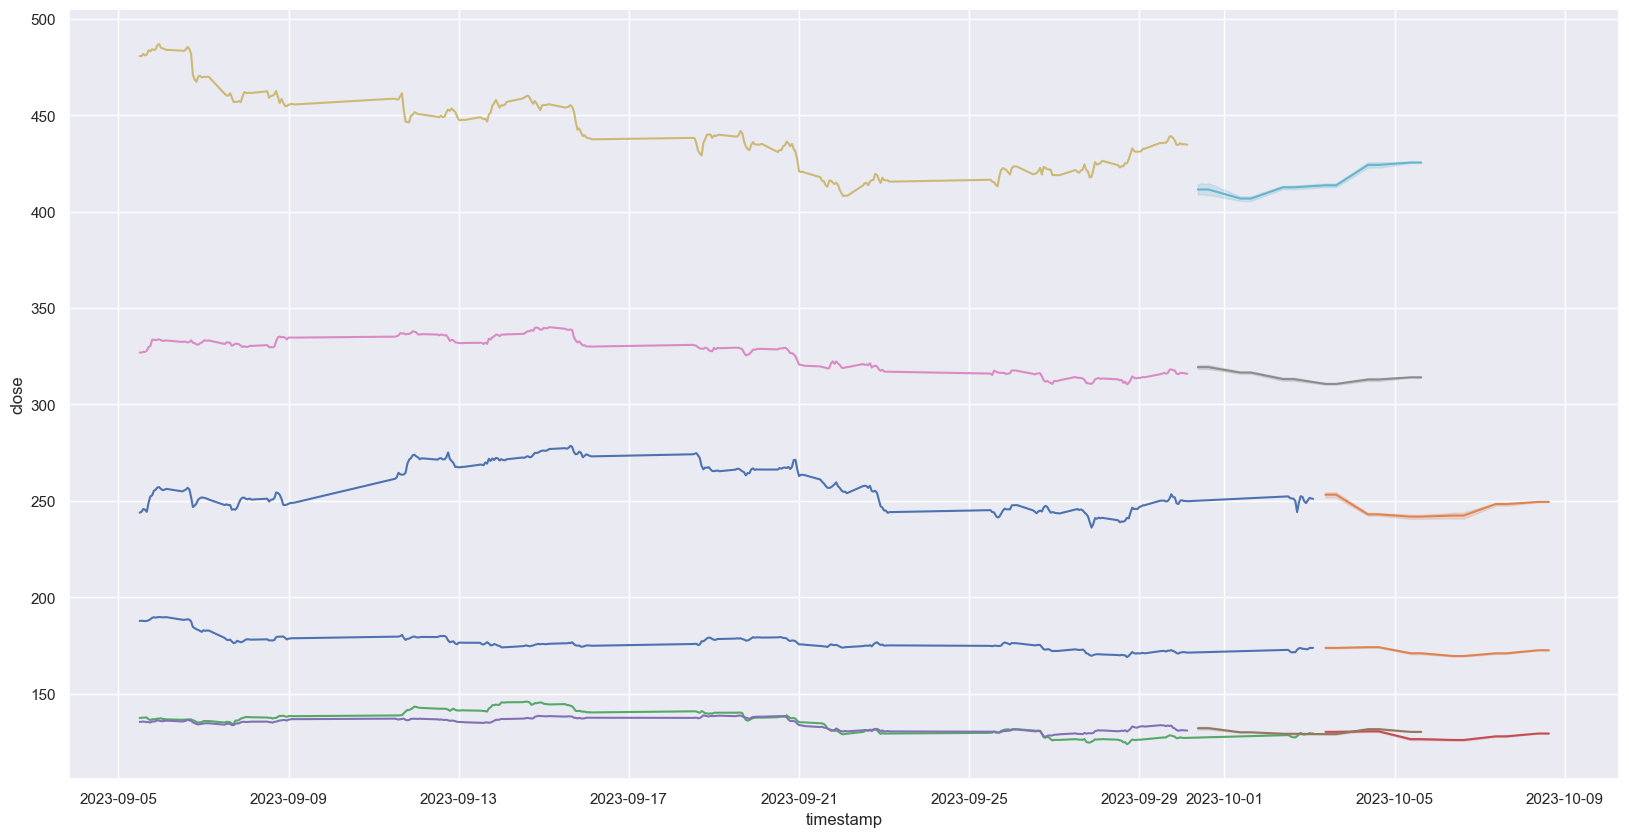

In [7]:
for symbol in symbols:
    ticker = symbol.lower()
    with gpu:
        DF = spark.read.format('delta').load(f"s3a://wonseokchoi-data-lake-project/lake/gold/{ticker}/")

        DF = DF.withColumn("timestamp", F.from_utc_timestamp("timestamp", "UTC"))
        DF = DF.withColumn("timestamp", F.expr("timestamp - interval 5 hours"))
        DF = DF.withColumn("timestamp", F.date_format("timestamp", 'yyyy-MM-dd HH:mm:ss'))
        DF = DF.withColumnRenamed("avg_close", "close") 
        DF = DF.select("timestamp", "close").orderBy("timestamp", ascending=True)

        df = DF.toPandas()

        train_timestamps = pd.to_datetime(df['timestamp'])
        cols = list(df)[1:2]
        df_for_training = df[cols].astype(float)
        
        scaler = StandardScaler()

        scaler = scaler.fit(df_for_training)
        df_for_training_scaled = scaler.transform(df_for_training)
        df_for_training_scaled

        trainX = []
        trainY = []

        n_future = 1
        n_past = 6*5*4

        with gpu: 
            for i in range (n_past, len(df_for_training_scaled) - n_future + 1):
                trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
                trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

            trainX, trainY = np.array(trainX), np.array(trainY)

        n_past = 1
        n_for_prediction = 24*5
        predict_period_dates = pd.date_range(list(train_timestamps)[-n_past], periods=n_for_prediction, freq='H').tolist()
        
        model = load_model("../models/tsla_bilstm.h5")
        
        prediction = model.predict(trainX[-n_for_prediction:])
        
        prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)

        prediction_copies.shape
        
        y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]

        # Function to replicate each business day to hourly intervals
        def replicate_to_hourly(business_days, trading_hours_start, trading_hours_end):
            hourly_timestamps = []
            for business_day in business_days:
                for hour in range(trading_hours_start, trading_hours_end):
                    new_time = pd.Timestamp(f"{business_day.date()} {hour:02d}:00:00")
                    hourly_timestamps.append(new_time)
            return pd.Series(hourly_timestamps)

        # Define trading hours
        trading_hours_start = 9  # 9:30 a.m. rounded down
        trading_hours_end = 16  # 4:00 p.m.

        hourly_timestamps = replicate_to_hourly(predict_period_dates, trading_hours_start, trading_hours_end)

        df_forecast = pd.DataFrame({
            'timestamp': hourly_timestamps,
            'close': np.repeat(y_pred_future, trading_hours_end - trading_hours_start)
        })

        df_forecast['timestamp'] = pd.to_datetime(df_forecast['timestamp'])

        month = (datetime.today() - timedelta(days=30)).strftime('%Y-%m-%d')

        original = df[['timestamp', 'close']].copy()
        original['timestamp'] = pd.to_datetime(original['timestamp'])

        original = original.loc[original['timestamp'] >= month]

        sns.set(rc={'figure.figsize':(20, 10)})
        sns.lineplot(x='timestamp', y='close', data=original)
        sns.lineplot(x='timestamp', y='close', data=df_forecast)
        
        # Calculate metrics
        y_true = df_for_training[-n_for_prediction:]
        mae = mean_absolute_error(y_true, y_pred_future)
        mse = mean_squared_error(y_true, y_pred_future)
        rmse = sqrt(mse)
        r2 = r2_score(y_true, y_pred_future)

        print("=="*20)
        print(f"Metrics for {ticker.upper()}")
        print(f'Mean Absolute Error: {mae}')
        print(f'Mean Squared Error: {mse}')
        print(f'Root Mean Squared Error: {rmse}')
        print(f'R-squared: {r2}')

        df_forecast['timestamp_str'] = df_forecast['timestamp'].astype(str)

        DF_forecast = spark.createDataFrame(df_forecast)
        DF_forecast = DF_forecast.withColumn("timestamp", to_utc_timestamp(col("timestamp_str"), "UTC"))
        DF_forecast = DF_forecast.drop('timestamp')
        DF_forecast = DF_forecast.withColumnRenamed("timestamp_str", "timestamp")
        DF_forecast = DF_forecast.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))

        save_path = f"s3a://wonseokchoi-data-lake-project/lake/ml/{ticker}/"

        with cpu: 
            DF_forecast.write \
                .format("delta") \
                .mode("overwrite") \
                .save(save_path)

            DF_forecast.write\
                .format("org.apache.spark.sql.cassandra")\
                .options(table=ticker, keyspace="ml")\
                .option("confirm.truncate", "true")\
                .mode("overwrite")\
                .save()

In [8]:
spark.stop()